To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
!pip install -U bitsandbyte

ERROR: Could not find a version that satisfies the requirement bitsandbyte (from versions: none)
ERROR: No matching distribution found for bitsandbyte


### Unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.18 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Load and process the dataset

In [ ]:
def format_chat_template(row):
    system_message = """You are an HR professional responsible for determining the yearly salary of a given job. Based on the provided job details—such as work type, required skills, educational qualifications, experience level, and preferred qualifications—return only the estimated yearly salary as a number, without any explanations or additional text.
        """
    #for llama & QWEN
    row_json = [{"role": "system", "content": system_message },
               {"role": "user", "content": row["question"]},
               {"role": "assistant", "content": str(row["answer"])}]

    #for gemma
    # row_json = [{"role": "user", "content": row["question"]},
    #            {"role": "assistant", "content": row["answer"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

In [ ]:
from datasets import load_dataset
dataset = load_dataset("MisterMekdonelds/cleaned_jd_dataset_with_title_location",split="train")


README.md:   0%|          | 0.00/315 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.55M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14812 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size = 0.2, seed = 42) #NEED THE SEED

In [ ]:
dataset_cleaned = dataset.map(format_chat_template)

Map:   0%|          | 0/11849 [00:00<?, ? examples/s]

Map:   0%|          | 0/2963 [00:00<?, ? examples/s]

In [ ]:
dataset_cleaned

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'text'],
        num_rows: 11849
    })
    test: Dataset({
        features: ['question', 'answer', 'text'],
        num_rows: 2963
    })
})

In [ ]:
dataset_cleaned['train']['text'][0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are an HR professional responsible for determining the yearly salary of a given job. Based on the provided job details—such as work type, required skills, educational qualifications, experience level, and preferred qualifications—return only the estimated yearly salary as a number, without any explanations or additional text.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n<Job Title>\nSr Product Sales Specialist, qPCR\n\n<Location>\nPortland, OR\n\n<Work Type>\nFull-time\n\n<Required Skills>\nMarket knowledge of genetic testing, Sales experience, Ability to drive for results, Communication skills, and ability to build relationships\n\n<Educational Requirements>\nBachelor’s Degree in Biology, Molecular Biology, Biochemistry or related field; or the equivalent knowledge and experience.\n\n<Experience Level>\n4+ years of sales experience in Life Scien

### Train it

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_cleaned['train'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/11849 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/11849 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/11849 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=2):   0%|          | 0/11849 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the

*   List item
*   List item

assistant outputs and ignore the loss on the user's inputs.

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=2):   0%|          | 0/11849 [00:00<?, ? examples/s]

We verify masking is actually done:

In [ ]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are an HR professional responsible for determining the yearly salary of a given job. Based on the provided job details—such as work type, required skills, educational qualifications, experience level, and preferred qualifications—return only the estimated yearly salary as a number, without any explanations or additional text.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n<Job Title>\nInterconnection Manager - Solar and Renewable Energy\n\n<Location>\nUnited States\n\n<Work Type>\nFull-time\n\n<Required Skills>\nAC interconnection design, communication, experience with Helioscope, MISO and PJM\n\n<Educational Requirements>\nBS degree in Engineering Field or equivalent industry experience\n\n<Experience Level>\n3+ years\n\n<Preferred Qualifications>\nBS degree in Engineering Field or equivalent industry experience, experience with t

In [ ]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                                                                                                                    160000.0<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
5.516 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 11,849 | Num Epochs = 1 | Total steps = 1,481
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,4.048200
2,4.701400
3,3.309700
4,2.360000
5,1.749000
6,1.444700
7,2.077900
8,1.208800
9,2.781800
10,1.882700


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

446.5262 seconds used for training.
7.44 minutes used for training.
Peak reserved memory = 6.531 GB.
Peak reserved memory for training = 3.896 GB.
Peak reserved memory % of max memory = 44.284 %.
Peak reserved memory for training % of max memory = 26.417 %.


In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The Fibonacci sequence is a series of numbers where each number is the sum of the two preceding numbers. 

The sequence you provided was: 1, 1, 2, 3, 5, 8, 13

The next number in the sequence would be 21, which is 8 + 13. The sequence continues as: 21, 34, 55, 89, 144, 233.<|eot_id|>


### Save the model


In [ ]:
# model.save_pretrained("lora_model")  # Local saving
# tokenizer.save_pretrained("lora_model")
model.push_to_hub("MisterMekdonelds/lora_model_r16_a16_llama3.1_8b_salary", token = "") # Online saving
tokenizer.push_to_hub("MisterMekdonelds/lora_model_r16_a16_llama3.1_8b_salary", token = "") # Online saving

README.md:   0%|          | 0.00/615 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/MisterMekdonelds/lora_model_r16_a16_llama3.1_8b_salary


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
model.push_to_hub_merged("MisterMekdonelds/merged_model_r16_a16_llama3.1_8b_salary", tokenizer, save_method = "merged_16bit", token = "")


Unsloth: You are pushing to hub, but you passed your HF username = MisterMekdonelds.
We shall truncate MisterMekdonelds/merged_model_r16_a16_llama3.1_8b_salary to merged_model_r16_a16_llama3.1_8b_salary
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.34 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


 34%|███▍      | 11/32 [00:00<00:01, 14.69it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [03:38<00:00,  6.84s/it]


Unsloth: Saving tokenizer...

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

 Done.
Unsloth: Saving merged_model_r16_a16_llama3.1_8b_salary/pytorch_model-00001-of-00004.bin...
Unsloth: Saving merged_model_r16_a16_llama3.1_8b_salary/pytorch_model-00002-of-00004.bin...
Unsloth: Saving merged_model_r16_a16_llama3.1_8b_salary/pytorch_model-00003-of-00004.bin...
Unsloth: Saving merged_model_r16_a16_llama3.1_8b_salary/pytorch_model-00004-of-00004.bin...


README.md:   0%|          | 0.00/615 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/MisterMekdonelds/merged_model_r16_a16_llama3.1_8b_salary


## Eval part

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model1, tokenizer1 = FastLanguageModel.from_pretrained(
    model_name = "MisterMekdonelds/lora_model_r16_a16_llama3.1_8b_salary", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
FastLanguageModel.for_inference(model1)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2025.3.18 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [ ]:
test = dataset_cleaned['test']

In [ ]:
test

Dataset({
    features: ['question', 'answer', 'text'],
    num_rows: 2963
})

In [ ]:
test = test.remove_columns("text")

In [ ]:
test

Dataset({
    features: ['question', 'answer'],
    num_rows: 2963
})

In [ ]:
print(test['question'][0])


<Job Title>
Senior Staff Accountant (26391)

<Location>
Cold Spring, MN

<Work Type>
Full-time

<Required Skills>
Financial data analysis, journal entries, and financial reporting.

<Educational Requirements>
2+ year degree in accounting.

<Experience Level>
3+ years in accounting.

<Preferred Qualifications>
Proficient in Microsoft Office, and strong communication skills.

The annual salary for this job is: 



In [ ]:
def format_chat_template(row):
    system_message = """You are an HR professional responsible for determining the yearly salary of a given job. Based on the provided job details—such as work type, required skills, educational qualifications, experience level, and preferred qualifications—return only the estimated yearly salary as a number, without any explanations or additional text.
        """
    #for llama & QWEN
    row_json = [{"role": "system", "content": system_message },
               {"role": "user", "content": row["question"]}]


    #for gemma
    # row_json = [{"role": "user", "content": row["question"]},
    #            {"role": "assistant", "content": row["answer"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False, add_generation_prompt=True)
    return row

In [ ]:
test = test.map(format_chat_template)

Map:   0%|          | 0/2963 [00:00<?, ? examples/s]

In [ ]:
test['text'][0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nYou are an HR professional responsible for determining the yearly salary of a given job. Based on the provided job details—such as work type, required skills, educational qualifications, experience level, and preferred qualifications—return only the estimated yearly salary as a number, without any explanations or additional text.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n<Job Title>\nSenior Staff Accountant (26391)\n\n<Location>\nCold Spring, MN\n\n<Work Type>\nFull-time\n\n<Required Skills>\nFinancial data analysis, journal entries, and financial reporting.\n\n<Educational Requirements>\n2+ year degree in accounting.\n\n<Experience Level>\n3+ years in accounting.\n\n<Preferred Qualifications>\nProficient in Microsoft Office, and strong communication skills.\n\nThe annual salary for this job is:<|eot_id|><|start_header_id|>assistant<|end_header_id

In [ ]:
from transformers import pipeline
from tqdm import tqdm
import torch

pipe = pipeline("text-generation", model = model, tokenizer = tokenizer, device_map='auto')

# Skip tokenization, since the pipeline wants to do that automatically.
pipe_dataloader = torch.utils.data.DataLoader(test['text'], batch_size = 8)
preds = []
for i, batch in enumerate(tqdm(pipe_dataloader)):
    outputs = pipe(batch, max_new_tokens = 100)
    preds.append(outputs)



Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausa

In [ ]:
def extract_answers_from_llm_outputs(outputs):
  all_values = []
  for sublist in outputs:
      # Iterate over each dictionary in the sublist
      for dictionary in sublist:
          # Iterate over the values of the dictionary and append them to the list
            all_values.append(dictionary[0]['generated_text'])


  final_answers = []
  import re
  for i in all_values:
    text = i.split("assistant")[1]
    match = re.search(r"(\d+)", text)
    if match:
      final_answers.append(int(match.group(1)))
    else:
      final_answers.append(0)

  return final_answers

y_pred = extract_answers_from_llm_outputs(preds)

In [ ]:
y_pred

In [ ]:
test['answer'][0]

77500.0

In [ ]:
def extract_answers_from_dataset(dataset):
  true_ans = []
  for ans in dataset['answer']:
    true_ans.append(int(ans))

  return true_ans

y_true = extract_answers_from_dataset(test)

R² Score: 0.6686
MSE: 1041734440.0236
RMSE: 32275.9111


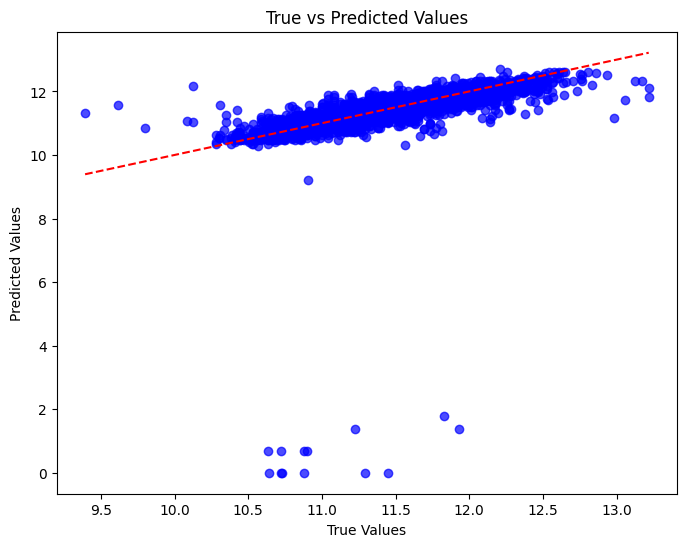

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score
import numpy as np
import matplotlib.pyplot as plt
def evaluate(y_true, y_pred):
      #regression metrics
      r2 = r2_score(y_true, y_pred)
      mse = mean_squared_error(y_true, y_pred)
      rmse = np.sqrt(mse)
      print(f"R² Score: {r2:.4f}")
      print(f"MSE: {mse:.4f}")
      print(f"RMSE: {rmse:.4f}")

      y_true = np.log1p(np.array(y_true))
      y_pred = np.log1p(np.array(y_pred))


      plt.figure(figsize=(8, 6))
      plt.scatter(y_true, y_pred, alpha=0.7, color='blue')  # Scatter plot of true vs predicted values
      plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')  # Line representing perfect predictions
      plt.xlabel('True Values')
      plt.ylabel('Predicted Values')
      plt.title('True vs Predicted Values')

      # Save the plot as an image file (e.g., 'true_vs_predicted.png')
      plot_path = 'true_vs_predicted.png'
      plt.savefig(plot_path, bbox_inches="tight")

evaluate(y_true, y_pred)

In [ ]:
import pandas as pd
df = pd.DataFrame(y_pred)
df.to_csv("predictions.csv")